CFE Data Assimilation of USGS streamflow data. Real Data Example

In [1]:
import time
import hydroeval as he
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta
sys.path.insert(0, './CFE')
import bmi_cfe_originial
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

In [2]:
## Open BMI's for each file
#cfe_open = bmi_cfe_originial.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [3]:
## Initialize the BMI's
# Fake forcing data
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_modell.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json') # I am confused what this config file should look like


## Case study files
# cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
# cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
# cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

# enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
# usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')

## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_camels.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_camels.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_camels.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')


# 2016 and 2017 Case Study 
# cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')
# cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')
# cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')

# enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
# usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config_16_17.json')


                time  convective_fraction  longwave_radiation  \
0     5/15/2017 0:00                  0.0          316.922979   
1     5/15/2017 1:00                  0.0          316.927862   
2     5/15/2017 2:00                  0.0          316.927862   
3     5/15/2017 3:00                  0.0          321.724693   
4     5/15/2017 4:00                  0.0          321.724693   
..               ...                  ...                 ...   
763  6/15/2017 19:00                  0.0          360.924973   
764  6/15/2017 20:00                  0.0          360.924973   
765  6/15/2017 21:00                  0.0          352.119515   
766  6/15/2017 22:00                  0.0          352.119515   
767  6/15/2017 23:00                  0.0          352.119282   

     potential_energy  potential_evaporation      pressure  \
0                 0.0               0.123136   98347.08198   
1                 0.0               0.041147   98396.49712   
2                 0.0            

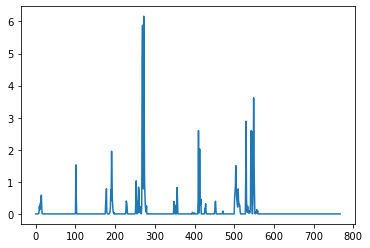

In [4]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['total_precipitation'])


Final Framework for running each CFE model, EnKF DA, and USGS. 

In [5]:
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

#Read in obs file for testing. Manually added no values to test EnKF without USGS
OBS = pd.read_csv('USGS_01123000_obs_streamflow.csv')

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['total_precipitation']):
    
    # Set values for each CFE model. Adding precipitation since we are using an uncalibrated model to see flow result
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip+1) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip+1)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip+1)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    #obs = np.array(usgs.get_value('Flow')) # Need array for EnKf function. Should get this when initialize CFS 
    new_flow = OBS['Flow'] #missing data values
   
    # Check validity when there is missing data
    validity = usgs.get_value('validity')[i]
    #print("-------------------------------------------------")
    #print("validity",validity)

    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state variable originial values from CFE Peturbed to update in EnKF
    #soil_storage_avail             = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    storage_max_m                  = cfe_peturbed.get_value("storage_max_out_m")
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    
    # Set outflow for CFE Open and CFE Peturbed to plot
    outflow = cfe_open.get_value('land_surface_water__runoff_depth') #m3/s
    cfeOpen.append(outflow) #for plotting
    
    # Get mean and covariance of CFE Peturbed outflor of ensemble runs for EnKF
    outflow_peturb       = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    outflow_peturb_mean  = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) #for plotting

    # Set EnKF state variable values to state variables from CFE Petubred
    #enkf.set_value('soil_storage_avail_m', soil_storage_avail)
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) 
    enkf.set_value('surface_runoff_depth_m', surface_runoff) 
    enkf.set_value('storage_max_m',storage_max_m)
    
    # Set EnkF values usgs, mean, and covariance (from CFE Peturbed)
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([new_flow[i]]))
    enkf_validity=enkf.set_value('validity',validity)
    enkf.update()
    #print("Observation", obs)

    # For plotting if needed
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    # Get updated state variable values from EnKF to pass into CFE Analysis
    #state_transition_soil_storage  = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res      = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    state_transition_runoff_factor = enkf.get_value('surface_runoff_ratio')

    # Set CFE analysis state variable changes from EnKF to get final true streamflow values
    #cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    cfe_analysis.update() #get new streamflow value based on state var change
    
    # For plotting CFE Analysis from newly updated state variables. FINAL MODEL! 
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) #for plotting
        
    # Get CFE Analysis state variables to then pass back into CFE Peturbed 
    #cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

    # Set updated state variables into CFE Peturbed for the loop of updating state variables to continue! 
    #cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
# Finalize the models! 
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
usgs.finalize()
enkf.finalize()

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:105: RuntimeWarning: invalid value encountered in floor_divide
  e.factor = e.res // e.x



GLOBAL MASS BALANCE
  initial volume:   0.6910
    volume input: 849.5306
   volume output: 847.9327
    final volume:   1.0794
        residual: -4.6378e-12

SCHAAKE MASS BALANCE
  surface runoff: 836.3886
    infiltration:  13.1420
schaake residual: -8.6562e-12

GIUH MASS BALANCE
  vol. into giuh: 836.3886
   vol. out giuh: 835.1791
 vol. end giuh q:   1.2095
   giuh residual: 3.3751e-14

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.6810
  vol. into soil:  13.1420
vol.soil2latflow:   7.6197
 vol. soil to gw:   5.2034
 final vol. soil:   0.9999
vol. soil resid.: 3.8192e-14

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   7.6197
  vol. from nash:   6.9580
 final vol. nash:   0.6617
nash casc resid.: 6.6835e-14

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   5.2034
     vol from gw:   5.1339
final gw.storage:   0.0795
    gw. residual: 9.9365e-15

GLOBAL MASS BALANCE
  initial volume:   0.6910
    vo

Plot the data to see the results of CFE Analysis! 

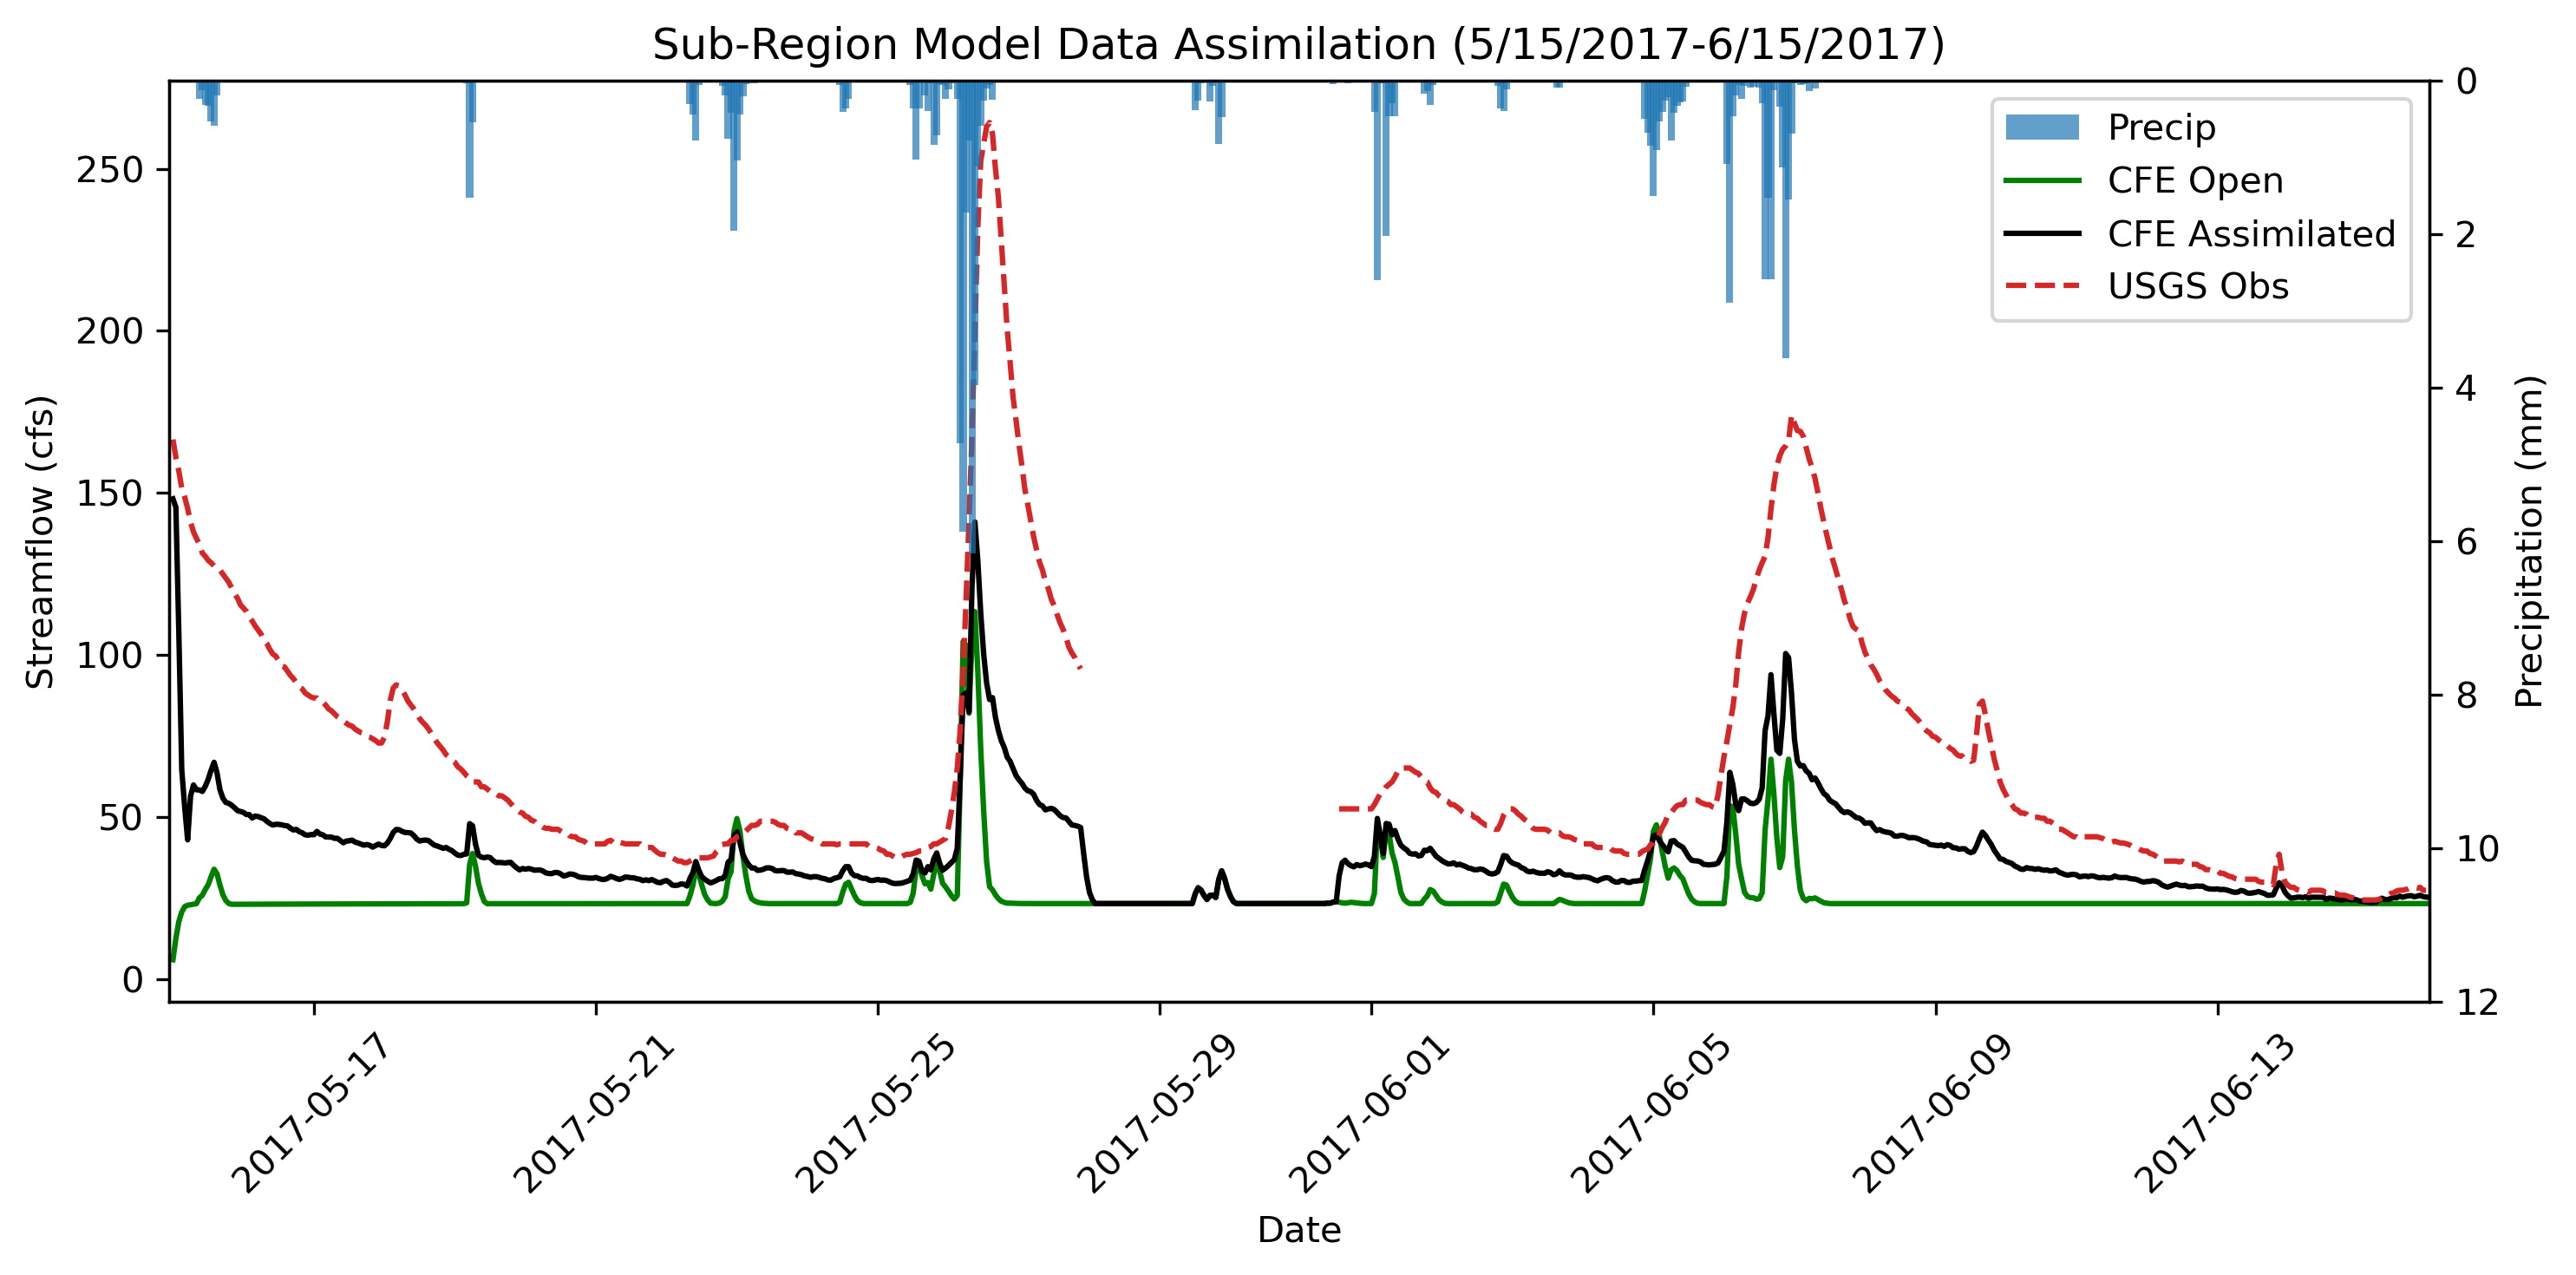

In [6]:
# Define time range for plotting
istart_plot = 0
iend_plot   = 720
x           = list(range(istart_plot, iend_plot))

# Get Date out of forcing file for plotting on x-axis
Date_list = []
df_forcing['time'] = pd.to_datetime(df_forcing['time'], infer_datetime_format=True) 

# Set plotting dimensions
fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

# Make double y-axis to plot precipitation on top of of the plot. Set labels and limits for axes
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()

ax1.set_xlabel('Date')
ax1.tick_params(axis='x', labelrotation = 45)
#ax1.set_xlim([date(2017, 5, 15), date(2017, 6, 15)]) ## Customize date range for all plots
ax1.set_ylabel('Streamflow (cfs)')

#plt.title('Sub-Region Model Data Assimilation (01/01/2016-12/31/2017)')
plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')

# Plot the variables on the plot! 
Precip    = ax2.bar(df_forcing['time'], df_forcing['total_precipitation'],width=0.1,alpha=0.7, color="tab:blue", label = 'Precip')
Open,     = ax1.plot(df_forcing['time'], cfeOpen, color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(df_forcing['time'], cfeAnalysis, color = 'black', label = 'CFE Assimilated')
Obs,      = ax1.plot(df_forcing['time'], new_flow, color = 'tab:red', linestyle = 'dashed', label = 'USGS Obs')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

# Plot the legend and fix layout
plt.legend(handles = [Precip,Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
fig.tight_layout()
ax1.margins(x=0)

#plt.savefig("SubRegionModel.png")
plt.show()


Get statistics to see the improvement of CFE Analysis

In [7]:
# Put values into dataframe to calculate statistics
df = pd.DataFrame({"obs":new_flow,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True) #drop NaN values
df.reset_index(drop=True, inplace=True) #reset index

# CFE Open Evaluation
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("CFE Open Statistics")
print("r_open     =",r_open[0])
print("KGE_open   =",kge_open[0])
print("NSE_open   =", nse_open[0])
print("PBIAS_open =", pbias_open[0])
print("--------------------------")

# CFE Analysis Evaluation
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("CFE Analysis Statistics")
print("r_analysis     =",r_analysis[0])
print("KGE_analysis   =",kge_analysis[0])
print("NSE_analysis   =", nse_analysis[0])
print("PBIAS_analysis =", pbias_analysis[0])
print("--------------------------")

# Mean and Std of Models and Observations
print("Mean and STD of Models and Observations")
print("mean_obs      =",np.mean(df["obs"]))
print("STD_obs       =",np.std(df["obs"]))
print("mean_open     =",np.mean(df["cfeOpen"]))
print("STD_open      =",np.std(df["cfeOpen"]))
print("mean_analysis =",np.mean(df["cfeAnalysis"]))
print("STD_analysis  =",np.std(df["cfeAnalysis"]))

CFE Open Statistics
r_open     = 0.3126066345130764
KGE_open   = -2.83765770996521
NSE_open   = -35.920767122823456
PBIAS_open = -157.39056034031708
--------------------------
CFE Analysis Statistics
r_analysis     = 0.8847876407120387
KGE_analysis   = -0.8155876980985901
NSE_analysis   = -5.462361896556842
PBIAS_analysis = -67.10907155440127
--------------------------
Mean and STD of Models and Observations
mean_obs      = 67.00701174743014
STD_obs       = 41.60538233271337
mean_open     = 26.033204814828796
STD_open      = 9.38771073064546
mean_analysis = 40.09777035091514
STD_analysis  = 15.50663761263989
